In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Load the Data

In [2]:
df = pd.read_csv('../ENGR 296 Project/Datasets/Turkey/01012016-04082020.csv')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, infer_datetime_format=True)
df['Hour'] = pd.to_datetime(df['Hour'])
df.loc[:,'Date'] = pd.to_datetime(df.Date.astype(str)+' '+df.Hour.astype(str))
df.drop(['Hour'], axis =1)
df.replace(',','', regex=True, inplace=True)
c = df.select_dtypes(object).columns
df[c] = df[c].apply(pd.to_numeric,errors='coerce')


                 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40272 entries, 0 to 40271
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype                                  
---  ------             --------------  -----                                  
 0   Date               40272 non-null  datetime64[ns, pytz.FixedOffset(-1020)]
 1   Hour               40272 non-null  datetime64[ns]                         
 2   Consumption (MWh)  40272 non-null  float64                                
dtypes: datetime64[ns, pytz.FixedOffset(-1020)](1), datetime64[ns](1), float64(1)
memory usage: 944.0 KB


In [4]:
df.tail()

,Date,Hour,Consumption (MWh)
40267,2020-08-04 19:00:00-17:00,2022-09-17 19:00:00,33876.52
40268,2020-08-04 20:00:00-17:00,2022-09-17 20:00:00,99.42
40269,2020-08-04 21:00:00-17:00,2022-09-17 21:00:00,0.00
40270,2020-08-04 22:00:00-17:00,2022-09-17 22:00:00,0.00
40271,2020-08-04 23:00:00-17:00,2022-09-17 23:00:00,0.00


In [5]:
df.head()

,Date,Hour,Consumption (MWh)
0,2016-01-01 00:00:00-17:00,2022-09-17 00:00:00,26277.24
1,2016-01-01 01:00:00-17:00,2022-09-17 01:00:00,24991.82
2,2016-01-01 02:00:00-17:00,2022-09-17 02:00:00,23532.61
3,2016-01-01 03:00:00-17:00,2022-09-17 03:00:00,22464.78
4,2016-01-01 04:00:00-17:00,2022-09-17 04:00:00,22002.91


In [6]:
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)

<AxesSubplot:title={'center':"Turkey's Energy Use in MWh"}, xlabel='Date'>

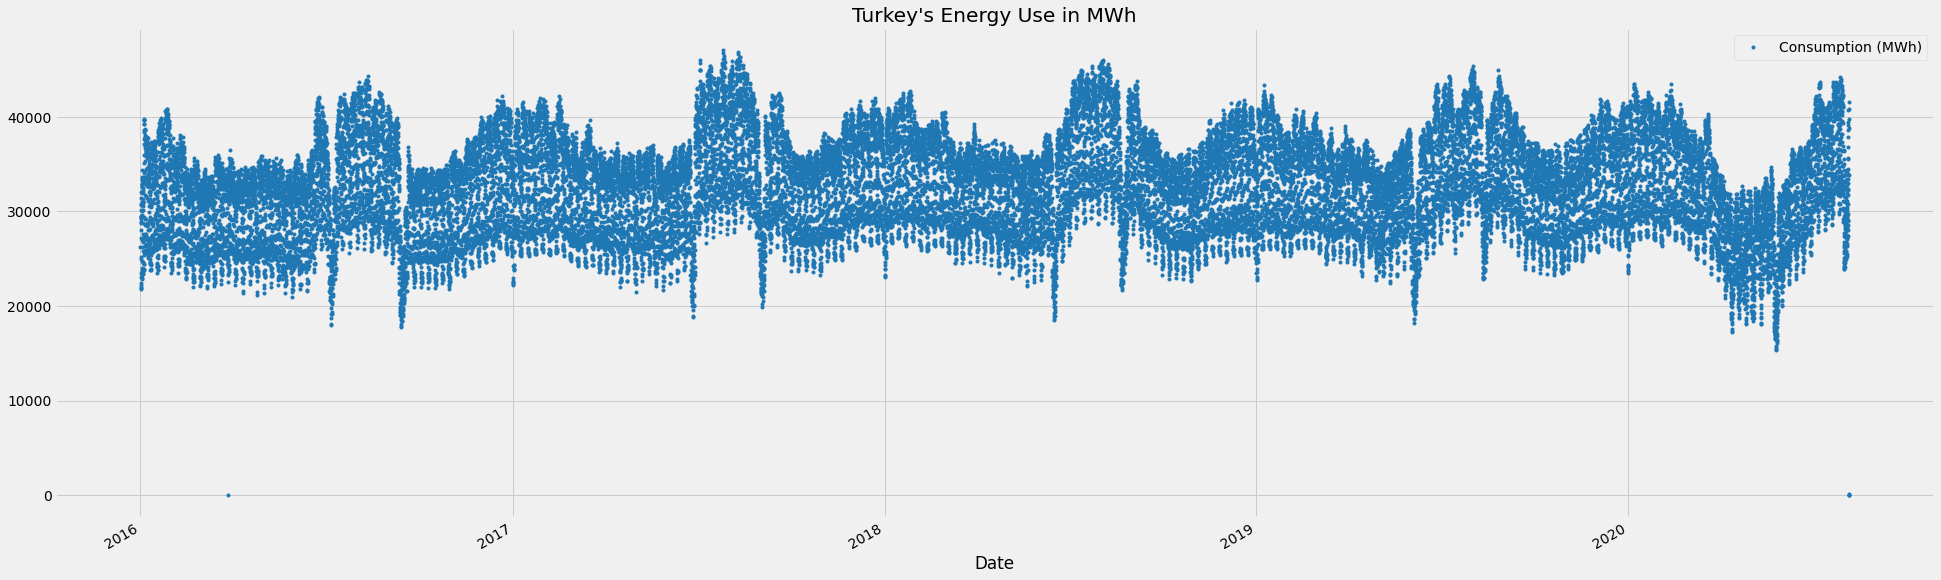

In [7]:
df.plot(y='Consumption (MWh)', style='.',
        figsize=(30, 10),
        color=color_pal[0],
        title="Turkey's Energy Use in MWh")



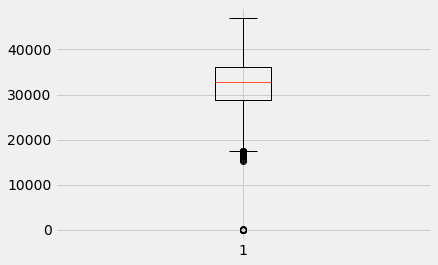

In [8]:
plt.boxplot(df["Consumption (MWh)"])
plt.show()

 

In [9]:
print(df['Consumption (MWh)'].quantile(0.10))
print(df['Consumption (MWh)'].quantile(0.90))
print(df['Consumption (MWh)'].quantile(0.50))

26094.634000000002
39337.854
32781.42


In [10]:
df["Consumption (MWh)"] = np.where(df["Consumption (MWh)"] < 10094, 32781, df["Consumption (MWh)"])
df.describe()

,Consumption (MWh)
count,40272.000000
mean,32605.746878
std,5023.940512
min,15333.300000
25%,28679.082500
50%,32781.420000
75%,36176.870000
max,47062.400000


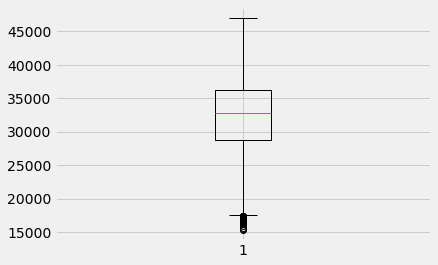

In [11]:
plt.boxplot(df["Consumption (MWh)"])
plt.show()

<AxesSubplot:title={'center':"Turkey's Energy Use in MWh"}, xlabel='Date'>

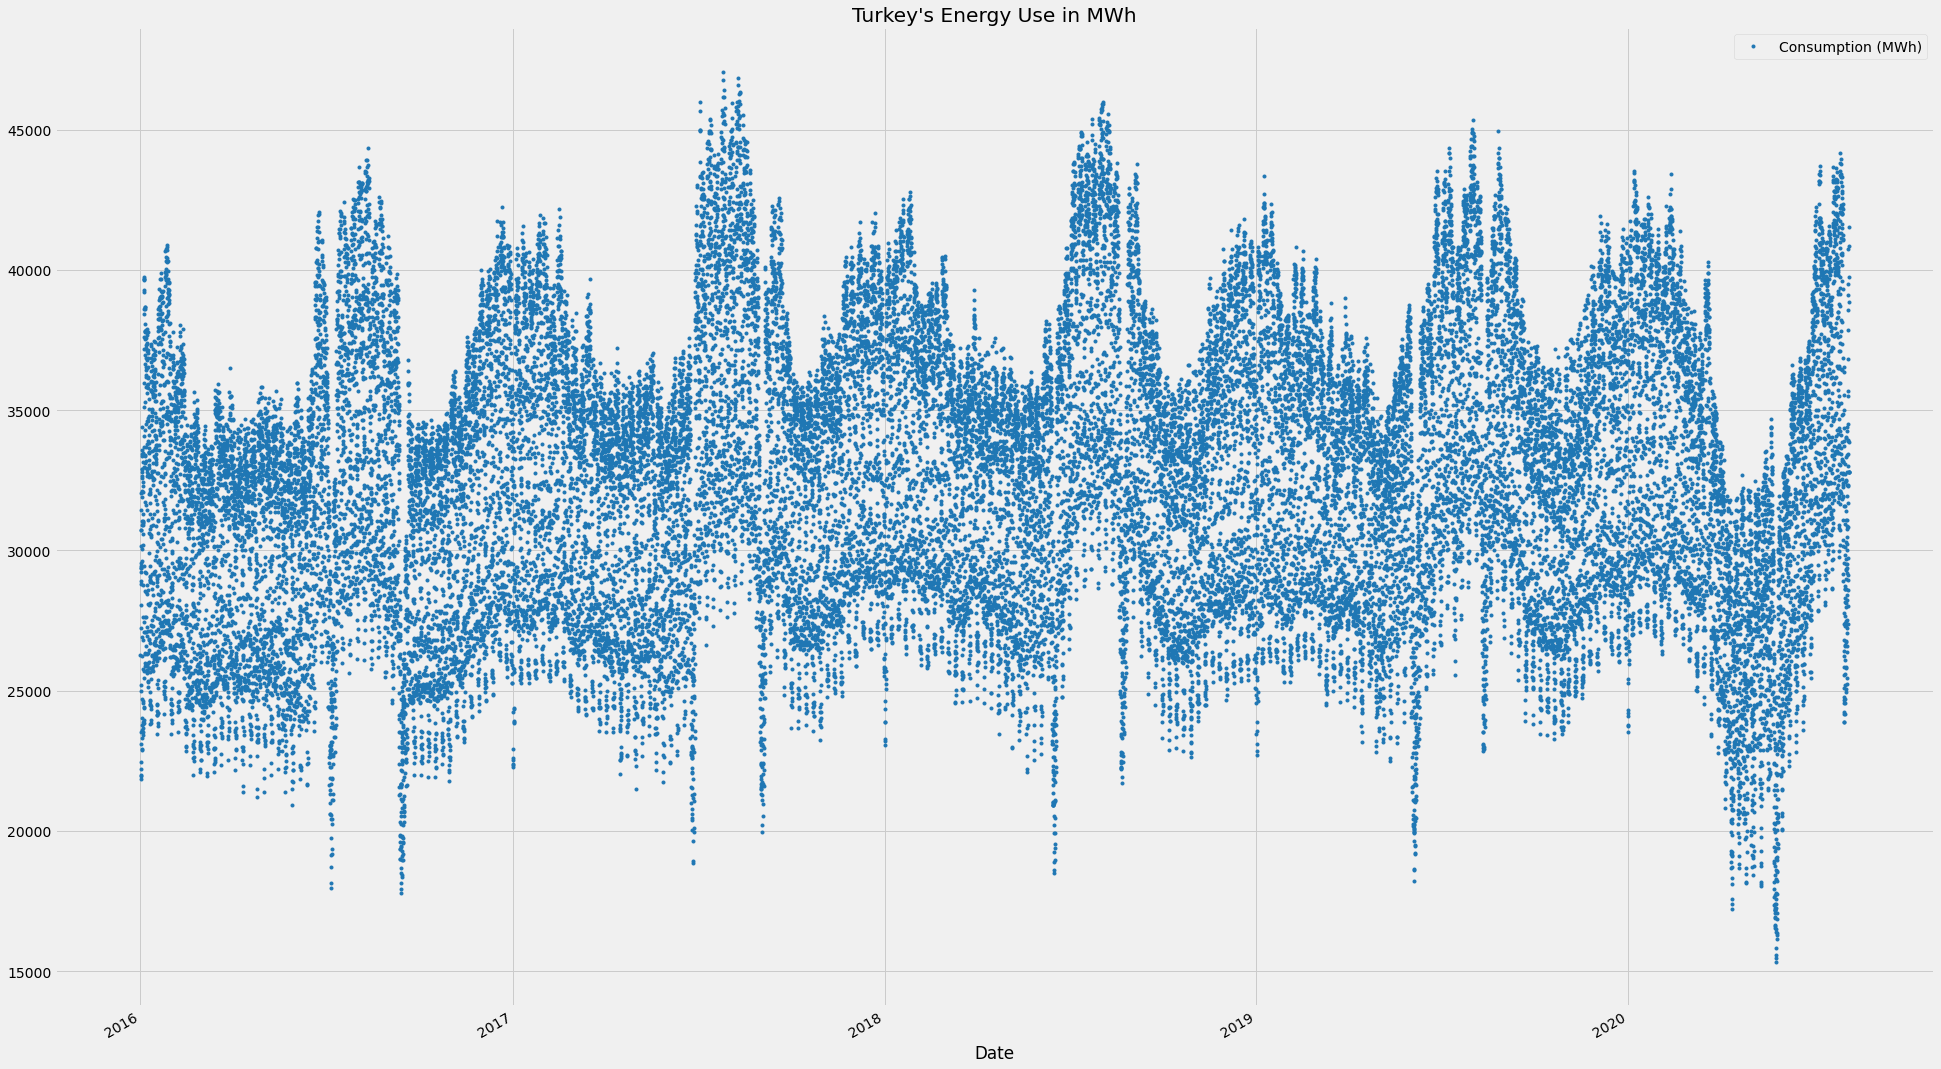

In [12]:
df.plot(y='Consumption (MWh)', style='.',
        figsize=(30, 20),
        color=color_pal[0],
        title="Turkey's Energy Use in MWh")

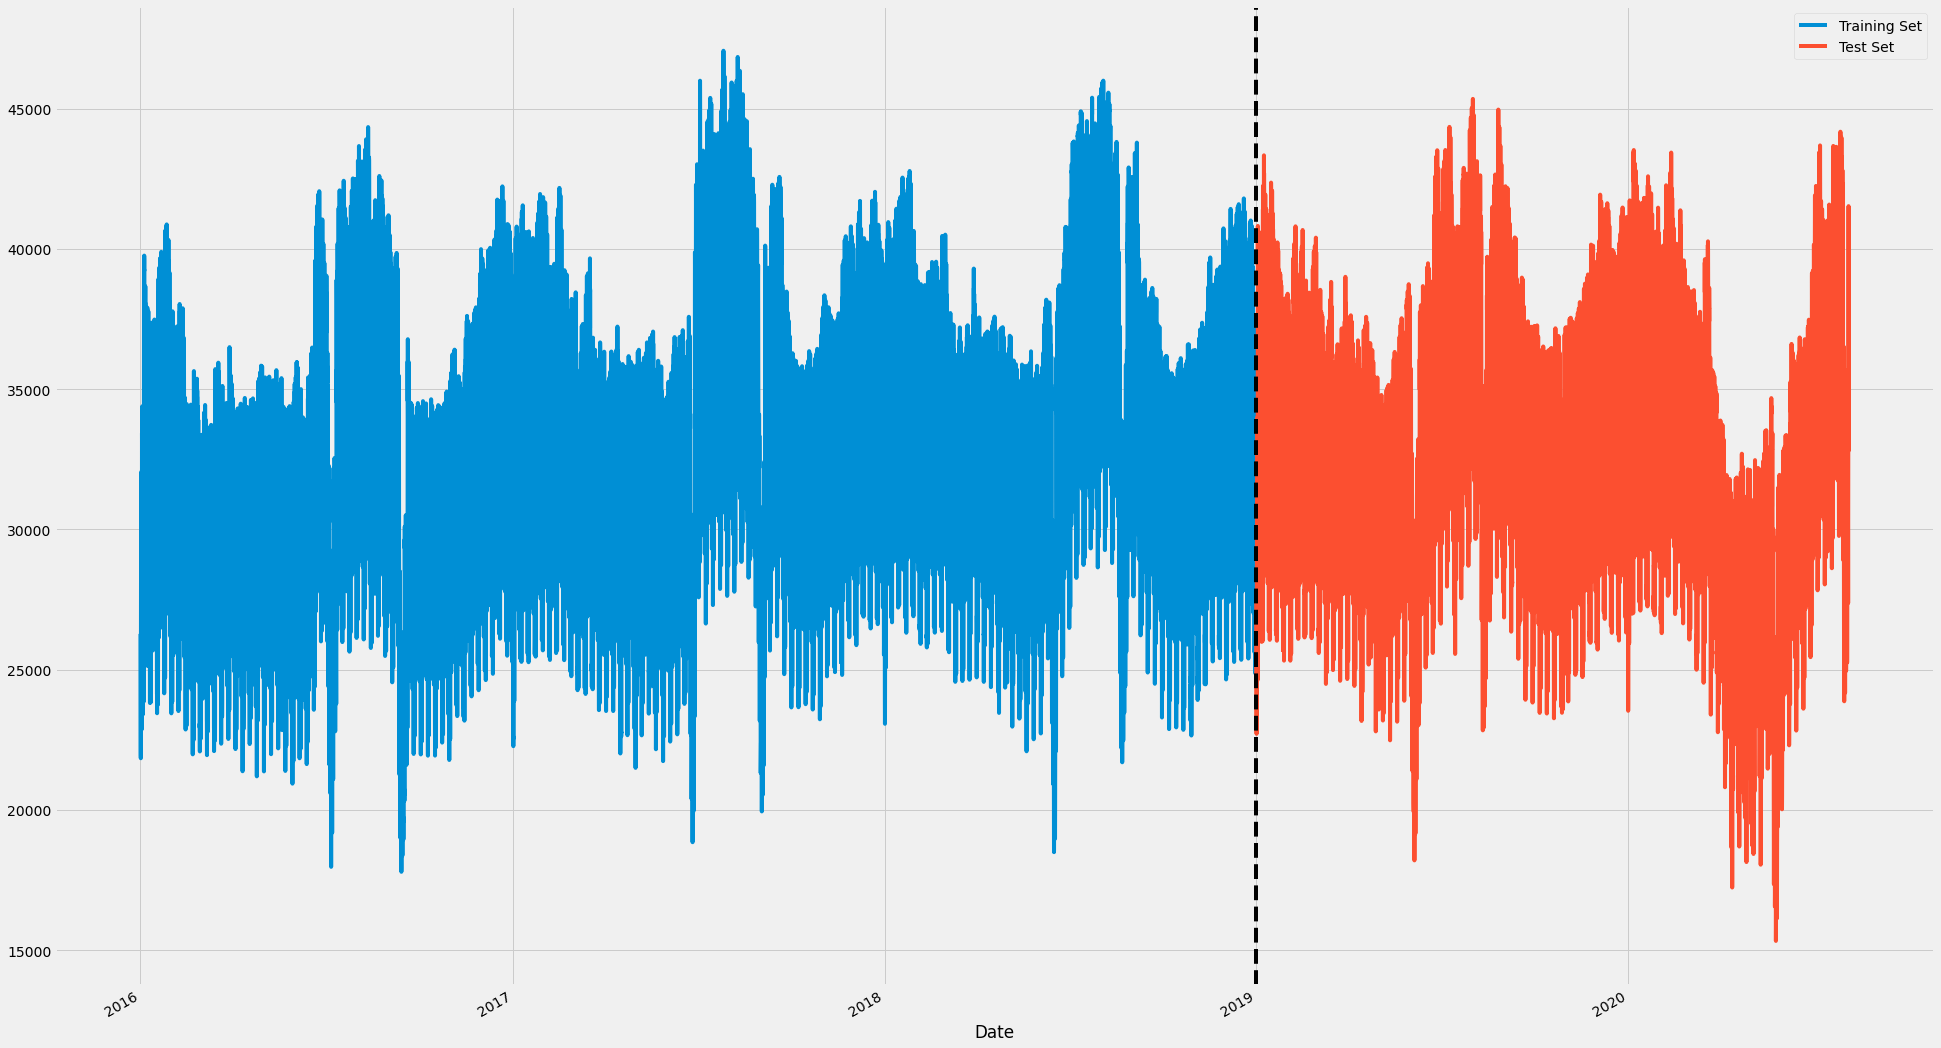

In [13]:
train = df.loc[df.index < '01-01-2019']
test = df.loc[df.index >= '01-01-2019']

fig, ax = plt.subplots(figsize=(30, 20))
train.plot(y='Consumption (MWh)', ax=ax, label= 'Training Set')
test.plot(y='Consumption (MWh)', ax=ax, label = "Test Set")
ax.axvline('01-01-2019', color = 'black', ls = '--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [14]:
df.head()

,Hour,Consumption (MWh)
Date,,
2016-01-01 00:00:00-17:00,2022-09-17 00:00:00,26277.24
2016-01-01 01:00:00-17:00,2022-09-17 01:00:00,24991.82
2016-01-01 02:00:00-17:00,2022-09-17 02:00:00,23532.61
2016-01-01 03:00:00-17:00,2022-09-17 03:00:00,22464.78
2016-01-01 04:00:00-17:00,2022-09-17 04:00:00,22002.91


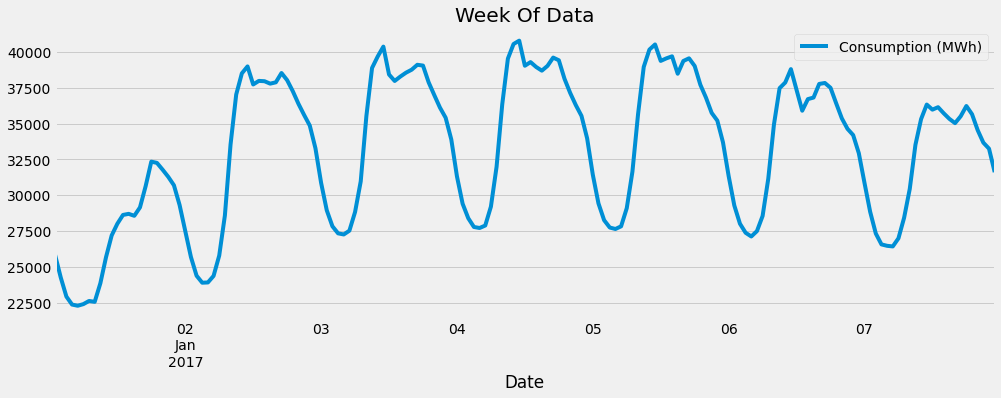

In [15]:
fig, ax = plt.subplots(figsize=(15, 5))
df.loc[(df.index > '01-01-2017') & (df.index < '01-08-2017')] \
    .plot(y = 'Consumption (MWh)', ax=ax, title='Week Of Data')

plt.show()


# Time Series Cross Validation

In [26]:
from sklearn.model_selection import TimeSeriesSplit

In [37]:
tss = TimeSeriesSplit(n_splits=4, test_size=24*365*1, gap=24)
df = df.sort_index()

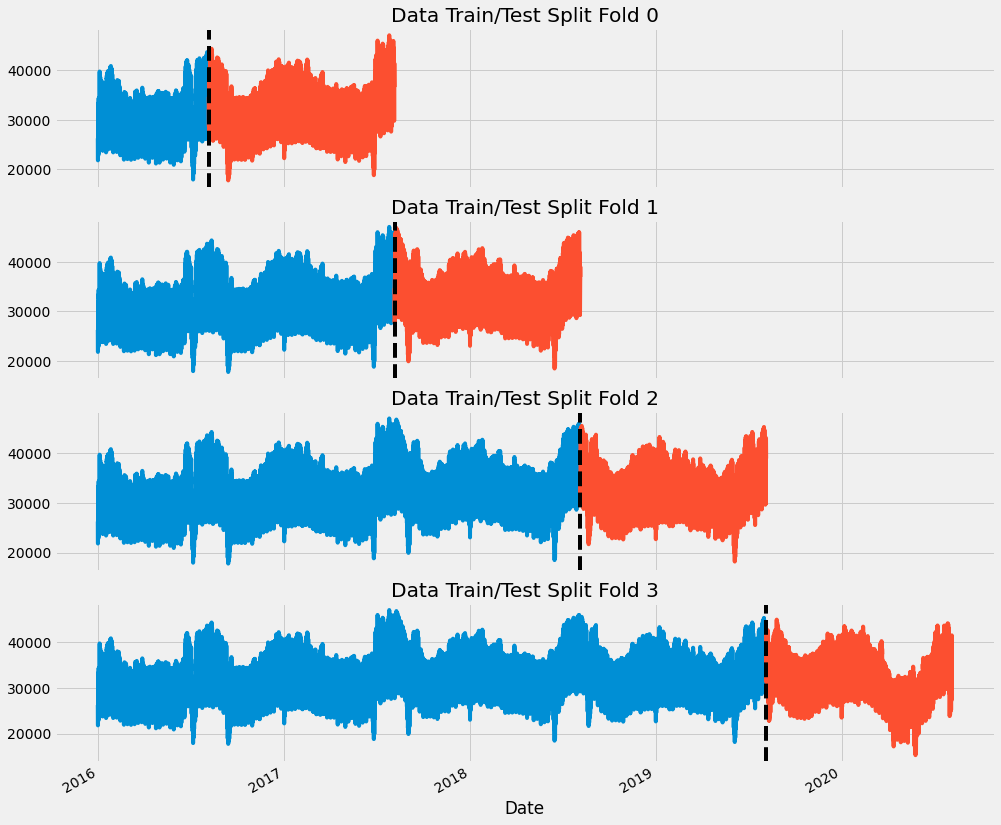

In [39]:
fig, axs = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Consumption (MWh)'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Consumption (MWh)'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [16]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

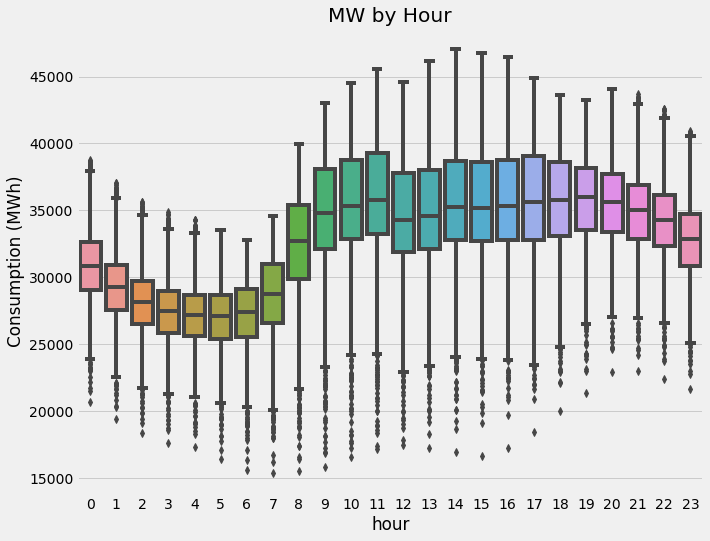

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='Consumption (MWh)')
ax.set_title('MW by Hour')
plt.show()

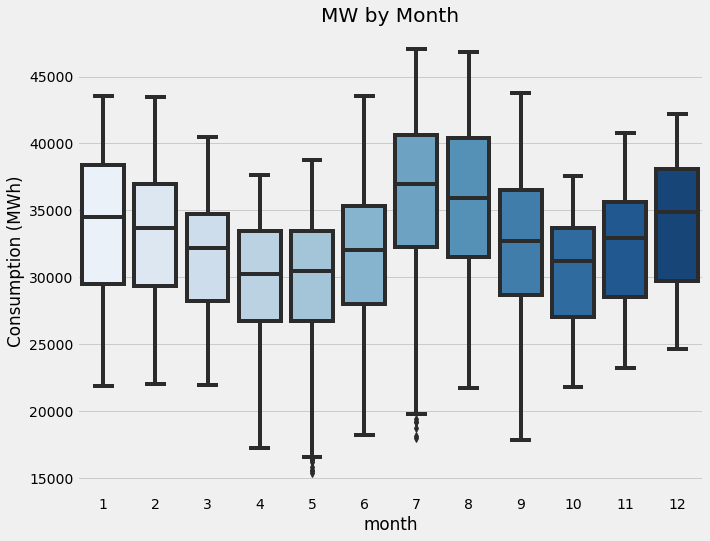

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='Consumption (MWh)', palette='Blues')
ax.set_title('MW by Month')
plt.show()

In [19]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'Consumption (MWh)'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [20]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[20:32:31] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:32:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:32632.09375	validation_1-rmse:32723.13672
[100]	validation_0-rmse:12286.25488	validation_1-rmse:12364.99414
[200]	validation_0-rmse:5177.66895	validation_1-rmse:5376.65332
[300]	validation_0-rmse:2887.87720	validation_1-rmse:3387.31641
[400]	validation_0-rmse:2251.06885	validation_1-rmse:3014.14526
[500]	validation_0-rmse:2047.19043	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

# Feature Importance

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
                 index=reg.n_features_in_,
                 columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test

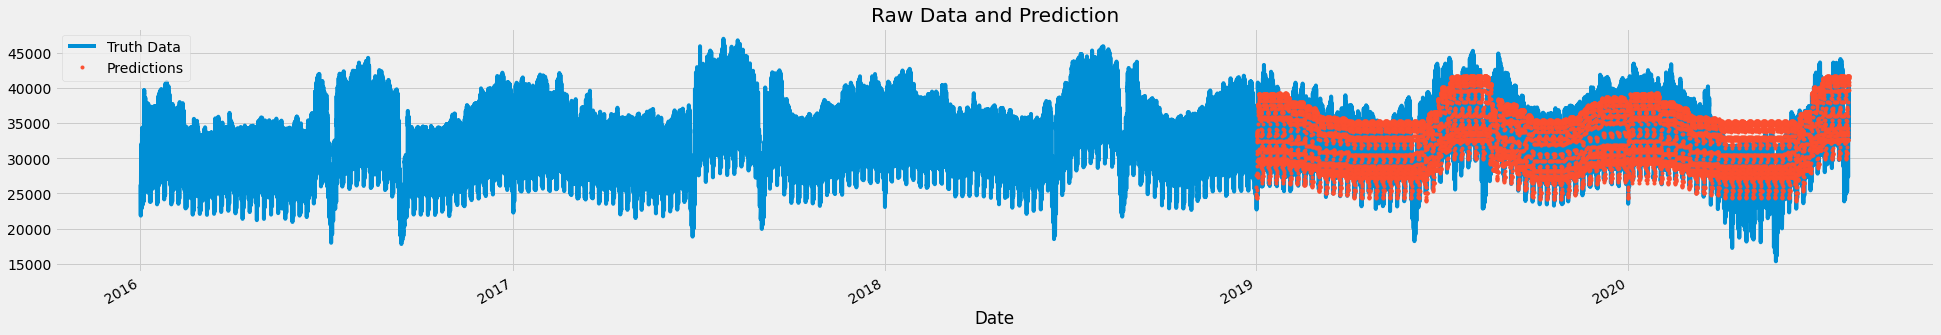

In [22]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Consumption (MWh)']].plot(figsize=(30, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

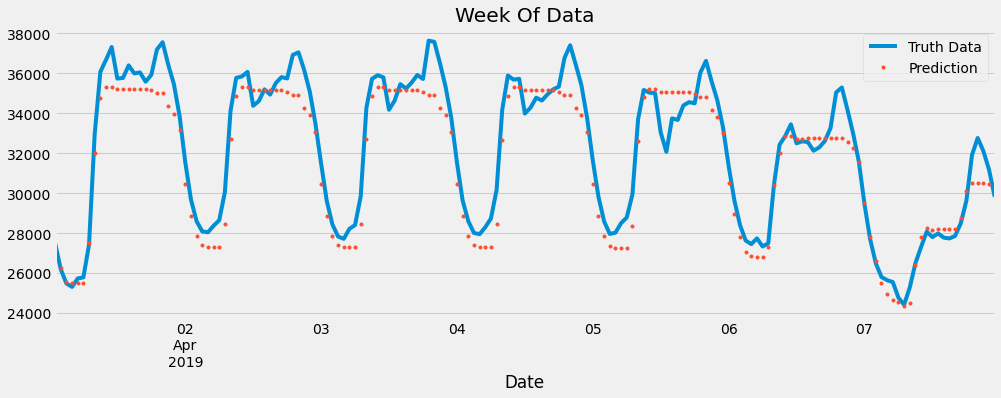

In [23]:
ax = df.loc[(df.index > '04-01-2019') & (df.index < '04-08-2019')]['Consumption (MWh)'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2019') & (df.index < '04-08-2019')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Score (RMSE)

In [24]:
score = np.sqrt(mean_squared_error(test['Consumption (MWh)'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 2886.72


# Calculate Error
- Look at the worst and best predicted days

In [25]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2020-05-25    12635.814642
2020-05-26    12272.776598
2020-07-31    10975.670928
2019-08-12    10622.351279
2019-06-04    10437.914424
2019-06-05    10236.866416
2019-08-13    10086.369733
2019-06-06     8923.018060
2020-05-23     8694.536143
2020-05-24     8664.845902
Name: error, dtype: float64

# Next Steps
- More robust cross validation
- Add more features (weather forecast, holidays)

# The End